In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
# Load saved data
from google.colab import drive
drive.mount('/content/drive')
data = np.load('/content/drive/My Drive/Github/mtc-device-activation/data/activity-models/e2-general-model.npz', allow_pickle=True)
all_DeviceLocations = data['all_DeviceLocations']
num_samples = data['num_samples']
device_count = data['device_count']
sparsity = data['sparsity']

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/data/communication-models/e2-communication-simulation-theta.npz", allow_pickle=True)
all_theta = data["all_theta"]

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/data/communication-models/e2-communication-simulation-gamma.npz", allow_pickle=True)
all_gamma = data["all_gamma"]

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/data/communication-models/e2-communication-simulation-z.npz", allow_pickle=True)
all_z = data["all_z"]

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/data/communication-models/e2-communication-simulation-noise.npz", allow_pickle=True)
all_noise = data["all_noise"]

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/data/communication-models/e2-communication-simulation-received-signal.npz", allow_pickle=True)
all_received_signal = data["all_received_signal"]

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/data/communication-models/e2-communication-simulation-general.npz", allow_pickle=True)
snr_db_array = data["snr_db_array"]
pilot_length_array = data["pilot_length_array"]
M = data["M"]

snr_db_index = 2
snr_db=snr_db_array[snr_db_index]

Mounted at /content/drive


In [ ]:
num_samples = 1000
sample_range = range(800, 1000)

Sparse Bayesian Learning (SBL)

In [ ]:
def casbl_anc_algorithm(theta, y, noise_var, loc, alpha=1.00, beta=0.1, rho=7, U=20, max_iter=500, stopping_criterion=1e-4):
    """Correlation Aware Sparse Bayesian Learning (CASBL) for Multiple Measurement Vectors (MMV)."""

    M = y.shape[1]  # Number of antennas (columns of y)

    L = theta.shape[0]  # Pilot Length (rows of theta)
    N = theta.shape[1] # Number of MTDs (columns of theta)

    # Initialize Gamma (covariance matrix of the signal)
    Gamma = np.eye(N) * 0.1  # Initial guess

    if rho == 0:
        correlation_matrix = np.eye(N)  # Identity matrix when no correlation
    else:
        # Compute pairwise distances (N x N matrix)
        distance_matrix = np.linalg.norm(loc[:, np.newaxis, :] - loc[np.newaxis, :, :], axis=2)

        # Compute exponential decay matrix
        correlation_matrix = np.maximum((np.exp(-distance_matrix / rho) - np.exp(-U / rho)) / (1 - np.exp(-U / rho)),0)

    # Outer loop over the maximum number of iterations
    for t in range(max_iter):
        # E-Step: Compute the mean (mu_x) and covariance (Sigma_x) of x
        Sigma_y = theta @ Gamma @ theta.conj().T + noise_var * np.eye(L)
        Sigma_y_inv = np.linalg.inv(Sigma_y)
        Sigma_x = Gamma - Gamma @ theta.conj().T @ Sigma_y_inv @ theta @ Gamma
        mu_x = Gamma @ theta.conj().T @ Sigma_y_inv @ y

        # Compute Q
        Q = (np.linalg.norm(mu_x, axis=1) ** 2) / M + np.diag(Sigma_x)

        # Compute P
        P = 2 * alpha * (beta - correlation_matrix) @ np.diag(Gamma)
        P = np.maximum(P, 1e-8)

        # Compute gamma update
        gamma_new = (np.sqrt(1 + 4 * P * Q) - 1) / (2 * P)

        # Ensure non-negativity (numerical stability)
        gamma_new = np.clip(np.real(gamma_new), 0, 1)

        # Update Gamma
        Gamma_old = np.diag(Gamma)
        Gamma = np.diagflat(gamma_new)

        # Check for convergence
        if np.linalg.norm(Gamma_old - gamma_new) < stopping_criterion:
            print(f"Converged after {t+1} outer iterations")
            break

    Gamma = np.where(Gamma < 0.05, 0, 1)

    Sigma_y = theta @ Gamma @ theta.conj().T + noise_var * np.eye(L)
    Sigma_y_inv = np.linalg.inv(Sigma_y)
    Sigma_x = Gamma - Gamma @ theta.conj().T @ Sigma_y_inv @ theta @ Gamma
    mu_x = Gamma @ theta.conj().T @ Sigma_y_inv @ y

    return mu_x, np.diag(Gamma)  # Final estimates


In [ ]:
# Placeholder arrays for results
z_res = np.zeros((num_samples, len(pilot_length_array), device_count, M), dtype=np.complex128)  # Z estimates
gamma_res = np.zeros((num_samples, len(pilot_length_array), device_count), dtype=bool)  # Gamma support

hr_res = np.zeros((num_samples, len(pilot_length_array)))         # HR
fr_res = np.zeros((num_samples, len(pilot_length_array)))         # FR
srr_res = np.zeros((num_samples, len(pilot_length_array)))        # SRR
precision_res = np.zeros((num_samples, len(pilot_length_array)))  # Precision
recall_res = np.zeros((num_samples, len(pilot_length_array)))     # Recall
f1_res = np.zeros((num_samples, len(pilot_length_array)))         # F1
nmse_res = np.zeros((num_samples, len(pilot_length_array)))       # NMSE

In [6]:
# Loop through each sample with an outer progress bar
for sample_index in tqdm(sample_range, desc="Processing Samples", position=0):
    gamma = all_gamma[sample_index]  # Ground truth gamma values (true support)
    loc = all_DeviceLocations[sample_index]

    # Loop over each SNR level with an inner progress bar
    for pilot_length_index in tqdm(range(len(pilot_length_array)), desc="Processing Pilot Length Levels", leave=False, position=1):
        pilot_length = pilot_length_array[pilot_length_index]
        theta = all_theta[sample_index, pilot_length_index, :pilot_length]
        received_signal = all_received_signal[sample_index, pilot_length_index, snr_db_index, :pilot_length]
        z = all_z[sample_index]
        snr = 10 ** (snr_db / 10)
        signal_power = np.mean(np.abs(np.matmul(theta, z))**2)
        noise_power = signal_power / snr

        # Apply SBL algorithm for the current sample and Pilot Length
        z_result, gamma_result = casbl_anc_algorithm(theta, received_signal, noise_power, loc)

        # Zero-out results with low gamma values
        z_result[gamma_result <= 0.05] = 0
        z_res[sample_index, pilot_length_index, :, :] = z_result
        gamma_result_bool =  gamma_result > 0.05
        gamma_res[sample_index, pilot_length_index, :] = gamma_result_bool

        # Compute number of active/inactive devices from ground truth
        active_devices = np.sum(gamma == 1)
        inactive_devices = np.sum(gamma == 0)

        # Hit rate: percentage of correctly identified active devices
        hr_res[sample_index, pilot_length_index] = (
            100 * np.sum((gamma_result_bool == 1) & (gamma == 1)) / active_devices if active_devices > 0 else 0
        )

        # False alarm rate: percentage of inactive devices wrongly detected as active
        fr_res[sample_index, pilot_length_index] = (
            100 * np.sum((gamma_result_bool == 1) & (gamma == 0)) / inactive_devices if inactive_devices > 0 else 0
        )

        # Support recovery rate: proportion of correctly identified active devices
        srr_res[sample_index, pilot_length_index] = (
            np.sum((gamma_result_bool == 1) & (gamma == 1)) /
            (np.sum((gamma_result_bool == 1) & (gamma == 0)) + np.sum((gamma_result_bool == 0) & (gamma == 1)) + sparsity)
        )

        # Classification metrics: TP, FP, FN
        TP = np.sum((gamma_result_bool == 1) & (gamma == 1))
        FP = np.sum((gamma_result_bool == 1) & (gamma == 0))
        FN = np.sum((gamma_result_bool == 0) & (gamma == 1))

        # Precision: proportion of predicted active devices that are actually active
        precision_res[sample_index, pilot_length_index] = TP / (TP + FP) if (TP + FP) > 0 else 0

        # Recall: proportion of actual active devices that are correctly identified
        recall_res[sample_index, pilot_length_index] = TP / (TP + FN) if (TP + FN) > 0 else 0

        # F1 Score: harmonic mean of precision and recall
        if (precision_res[sample_index, pilot_length_index] + recall_res[sample_index, pilot_length_index]) > 0:
            f1_res[sample_index, pilot_length_index] = (
                2 * precision_res[sample_index, pilot_length_index] * recall_res[sample_index, pilot_length_index]
                /
                (precision_res[sample_index, pilot_length_index] + recall_res[sample_index, pilot_length_index])
            )
        else:
            f1_res[sample_index, pilot_length_index] = 0

        # Normalized Mean Squared Error: compares estimated and true z vectors for active devices
        nmse_res[sample_index, pilot_length_index] = (
            np.linalg.norm(z[gamma == 1] - z_result[gamma == 1])**2 / np.linalg.norm(z[gamma == 1])**2
        )


Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:15<00:37, 18.87s/it]

Converged after 453 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:31<00:17, 17.86s/it]

Converged after 402 outer iterations



Processing Samples:   0%|          | 1/200 [01:45<5:51:08, 105.87s/it]

Converged after 323 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:15<00:38, 19.32s/it]

Converged after 500 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:30<00:17, 17.83s/it]

Converged after 369 outer iterations



Processing Samples:   1%|          | 2/200 [03:34<5:54:00, 107.28s/it]

Converged after 423 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:14<00:36, 18.07s/it]

Converged after 424 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:31<00:18, 18.00s/it]

Converged after 436 outer iterations



Processing Samples:   2%|▏         | 3/200 [05:22<5:53:22, 107.63s/it]

Converged after 370 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:33<00:18, 18.39s/it]

Converged after 384 outer iterations



Processing Samples:   2%|▎         | 5/200 [09:11<6:02:14, 111.46s/it]

Converged after 363 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:34<00:18, 18.99s/it]

Converged after 424 outer iterations



Processing Samples:   3%|▎         | 6/200 [11:04<6:01:28, 111.80s/it]

Converged after 435 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:30<00:17, 17.32s/it]

Converged after 340 outer iterations



Processing Samples:   4%|▎         | 7/200 [12:48<5:52:01, 109.44s/it]

Converged after 322 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:56<00:56, 18.80s/it]

Converged after 486 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:38<00:20, 20.27s/it]

Converged after 475 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:33<00:18, 18.78s/it]

Converged after 434 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:14<00:37, 18.84s/it]

Converged after 465 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:28<00:17, 17.07s/it]

Converged after 331 outer iterations



Processing Samples:   5%|▌         | 10/200 [18:26<5:49:05, 110.24s/it]

Converged after 318 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:14<00:38, 19.12s/it]

Converged after 464 outer iterations



Processing Samples:   6%|▌         | 11/200 [20:14<5:45:30, 109.69s/it]

Converged after 339 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:56<00:57, 19.20s/it]

Converged after 459 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:34<00:18, 19.00s/it]

Converged after 485 outer iterations



Processing Samples:   6%|▌         | 12/200 [22:02<5:41:55, 109.12s/it]

Converged after 308 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:29<00:17, 17.01s/it]

Converged after 323 outer iterations



Processing Samples:   6%|▋         | 13/200 [23:47<5:35:46, 107.74s/it]

Converged after 365 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:31<00:17, 17.82s/it]

Converged after 401 outer iterations



Processing Samples:   7%|▋         | 14/200 [25:31<5:30:44, 106.69s/it]

Converged after 283 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:12<00:35, 17.68s/it]

Converged after 411 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:30<00:17, 17.80s/it]

Converged after 449 outer iterations



Processing Samples:   8%|▊         | 15/200 [27:19<5:30:01, 107.03s/it]

Converged after 416 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:14<00:36, 18.42s/it]

Converged after 484 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:28<00:16, 16.81s/it]

Converged after 336 outer iterations



Processing Samples:   8%|▊         | 16/200 [29:03<5:25:57, 106.29s/it]

Converged after 367 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:13<00:36, 18.01s/it]

Converged after 463 outer iterations



Processing Samples:   8%|▊         | 17/200 [30:57<5:31:25, 108.66s/it]

Converged after 450 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:12<00:35, 17.96s/it]

Converged after 415 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:28<00:17, 17.49s/it]

Converged after 422 outer iterations



Processing Samples:   9%|▉         | 18/200 [32:40<5:23:55, 106.79s/it]

Converged after 317 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:33<00:19, 19.13s/it]

Converged after 470 outer iterations



Processing Samples:  10%|▉         | 19/200 [34:29<5:24:25, 107.55s/it]

Converged after 380 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:12<00:36, 18.02s/it]

Converged after 438 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:31<00:18, 18.10s/it]

Converged after 474 outer iterations



Processing Samples:  10%|█         | 20/200 [36:17<5:22:27, 107.49s/it]

Converged after 399 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:54<00:53, 17.81s/it]

Converged after 449 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:11<00:34, 17.26s/it]

Converged after 423 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:29<00:17, 17.67s/it]

Converged after 479 outer iterations



Processing Samples:  10%|█         | 21/200 [38:00<5:17:31, 106.43s/it]

Converged after 337 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:15<00:37, 18.91s/it]

Converged after 494 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:31<00:17, 17.76s/it]

Converged after 391 outer iterations



Processing Samples:  11%|█         | 22/200 [39:46<5:14:59, 106.18s/it]

Converged after 332 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:11<00:33, 16.93s/it]

Converged after 345 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:25<00:16, 16.10s/it]

Converged after 361 outer iterations



Processing Samples:  12%|█▏        | 23/200 [41:26<5:07:30, 104.24s/it]

Converged after 324 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:12<00:36, 18.06s/it]

Converged after 408 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:28<00:17, 17.37s/it]

Converged after 406 outer iterations



Processing Samples:  12%|█▏        | 24/200 [43:12<5:07:17, 104.76s/it]

Converged after 424 outer iterations



Processing Samples:  12%|█▎        | 25/200 [45:07<5:14:27, 107.82s/it]

Converged after 383 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:34<00:19, 19.34s/it]

Converged after 485 outer iterations



Processing Samples:  13%|█▎        | 26/200 [46:56<5:13:54, 108.24s/it]

Converged after 341 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:12<00:36, 18.01s/it]

Converged after 437 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:31<00:18, 18.25s/it]

Converged after 490 outer iterations



Processing Samples:  14%|█▎        | 27/200 [48:40<5:08:24, 106.96s/it]

Converged after 281 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:56<00:55, 18.61s/it]

Converged after 479 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:33<00:18, 18.81s/it]

Converged after 492 outer iterations



Processing Samples:  14%|█▍        | 28/200 [50:34<5:12:31, 109.02s/it]

Converged after 422 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:29<00:17, 17.69s/it]

Converged after 360 outer iterations



Processing Samples:  14%|█▍        | 29/200 [52:18<5:06:51, 107.67s/it]

Converged after 366 outer iterations



Processing Samples:  15%|█▌        | 30/200 [54:09<5:07:42, 108.60s/it]

Converged after 433 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:29<00:17, 17.23s/it]

Converged after 364 outer iterations



Processing Samples:  16%|█▌        | 31/200 [55:56<5:04:05, 107.96s/it]

Converged after 428 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:29<00:17, 17.07s/it]

Converged after 360 outer iterations
Converged after 416 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:35<00:19, 19.12s/it]

Converged after 455 outer iterations



Processing Samples:  16%|█▋        | 33/200 [59:37<5:05:43, 109.84s/it]

Converged after 462 outer iterations



Processing Samples:  17%|█▋        | 34/200 [1:01:32<5:07:49, 111.26s/it]

Converged after 397 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:32<00:18, 18.58s/it]

Converged after 421 outer iterations



Processing Samples:  18%|█▊        | 35/200 [1:03:22<5:05:04, 110.94s/it]

Converged after 447 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:15<00:37, 18.93s/it]

Converged after 458 outer iterations



Processing Samples:  18%|█▊        | 36/200 [1:05:18<5:07:00, 112.32s/it]

Converged after 468 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:14<00:37, 18.82s/it]

Converged after 463 outer iterations



Processing Samples:  18%|█▊        | 37/200 [1:07:06<5:01:49, 111.10s/it]

Converged after 345 outer iterations



Processing Samples:  19%|█▉        | 38/200 [1:08:53<4:56:46, 109.91s/it]

Converged after 316 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:35<00:19, 19.33s/it]

Converged after 426 outer iterations
Converged after 327 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:35<00:19, 19.14s/it]

Converged after 469 outer iterations



Processing Samples:  20%|██        | 40/200 [1:12:34<4:54:21, 110.38s/it]

Converged after 430 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:29<00:17, 17.35s/it]

Converged after 341 outer iterations



Processing Samples:  20%|██        | 41/200 [1:14:20<4:48:42, 108.95s/it]

Converged after 398 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:12<00:36, 18.13s/it]

Converged after 432 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:29<00:17, 17.47s/it]

Converged after 415 outer iterations



Processing Samples:  21%|██        | 42/200 [1:16:03<4:42:37, 107.32s/it]

Converged after 344 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:30<00:17, 17.82s/it]

Converged after 424 outer iterations



Processing Samples:  22%|██▏       | 43/200 [1:17:49<4:39:51, 106.95s/it]

Converged after 376 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:32<00:18, 18.77s/it]

Converged after 429 outer iterations



Processing Samples:  22%|██▏       | 44/200 [1:19:34<4:36:03, 106.18s/it]

Converged after 295 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:12<00:36, 18.07s/it]

Converged after 482 outer iterations



Processing Samples:  22%|██▎       | 45/200 [1:21:22<4:36:21, 106.97s/it]

Converged after 367 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:29<00:17, 17.79s/it]

Converged after 385 outer iterations



Processing Samples:  23%|██▎       | 46/200 [1:23:10<4:34:51, 107.09s/it]

Converged after 438 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:13<00:36, 18.20s/it]

Converged after 494 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:33<00:18, 18.76s/it]

Converged after 431 outer iterations



Processing Samples:  24%|██▎       | 47/200 [1:24:59<4:34:25, 107.62s/it]

Converged after 376 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:51<00:51, 17.22s/it]

Converged after 449 outer iterations



Processing Samples:  24%|██▍       | 48/200 [1:26:49<4:35:06, 108.60s/it]

Converged after 433 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:12<00:34, 17.48s/it]

Converged after 425 outer iterations



Processing Samples:  24%|██▍       | 49/200 [1:28:42<4:35:55, 109.64s/it]

Converged after 442 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:29<00:17, 17.70s/it]

Converged after 404 outer iterations



Processing Samples:  25%|██▌       | 50/200 [1:30:25<4:29:12, 107.68s/it]

Converged after 317 outer iterations



Processing Samples:  26%|██▌       | 52/200 [1:34:11<4:32:18, 110.39s/it]

Converged after 369 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:29<00:17, 17.47s/it]

Converged after 346 outer iterations



Processing Samples:  26%|██▋       | 53/200 [1:35:56<4:26:08, 108.63s/it]

Converged after 375 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:31<00:18, 18.41s/it]

Converged after 421 outer iterations



Processing Samples:  27%|██▋       | 54/200 [1:37:45<4:24:51, 108.85s/it]

Converged after 448 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:28<00:16, 17.00s/it]

Converged after 365 outer iterations



Processing Samples:  28%|██▊       | 55/200 [1:39:29<4:18:59, 107.17s/it]

Converged after 367 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:33<00:18, 18.46s/it]

Converged after 400 outer iterations



Processing Samples:  28%|██▊       | 56/200 [1:41:16<4:17:26, 107.27s/it]

Converged after 343 outer iterations



Processing Samples:  28%|██▊       | 57/200 [1:43:07<4:18:24, 108.42s/it]

Converged after 448 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:13<00:36, 18.12s/it]

Converged after 477 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:28<00:16, 16.87s/it]

Converged after 369 outer iterations



Processing Samples:  29%|██▉       | 58/200 [1:44:57<4:17:45, 108.91s/it]

Converged after 474 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:11<00:35, 17.75s/it]

Converged after 422 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:26<00:16, 16.88s/it]

Converged after 391 outer iterations



Processing Samples:  30%|██▉       | 59/200 [1:46:38<4:10:25, 106.56s/it]

Converged after 351 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:12<00:37, 18.77s/it]

Converged after 475 outer iterations



Processing Samples:  30%|███       | 60/200 [1:48:26<4:09:20, 106.86s/it]

Converged after 385 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:14<00:37, 18.63s/it]

Converged after 485 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:34<00:19, 19.20s/it]

Converged after 436 outer iterations



Processing Samples:  30%|███       | 61/200 [1:50:10<4:05:40, 106.04s/it]

Converged after 283 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:33<00:18, 18.21s/it]

Converged after 390 outer iterations



Processing Samples:  31%|███       | 62/200 [1:51:59<4:05:40, 106.82s/it]

Converged after 373 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:08<00:33, 16.83s/it]

Converged after 381 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:28<00:17, 17.84s/it]

Converged after 460 outer iterations



Processing Samples:  32%|███▏      | 63/200 [1:53:46<4:04:32, 107.10s/it]

Converged after 494 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:10<00:34, 17.02s/it]

Converged after 379 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:26<00:16, 16.44s/it]

Converged after 376 outer iterations



Processing Samples:  32%|███▏      | 64/200 [1:55:29<3:59:57, 105.87s/it]

Converged after 420 outer iterations



Processing Samples:  32%|███▎      | 65/200 [1:57:21<4:02:06, 107.60s/it]

Converged after 368 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:13<00:37, 18.96s/it]

Converged after 491 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:30<00:18, 18.24s/it]

Converged after 432 outer iterations



Processing Samples:  33%|███▎      | 66/200 [1:59:09<4:00:23, 107.64s/it]

Converged after 439 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:11<00:35, 17.52s/it]

Converged after 388 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:27<00:16, 16.91s/it]

Converged after 402 outer iterations



Processing Samples:  34%|███▎      | 67/200 [2:00:50<3:54:28, 105.78s/it]

Converged after 326 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:30<00:17, 17.86s/it]

Converged after 431 outer iterations



Processing Samples:  34%|███▍      | 68/200 [2:02:36<3:52:39, 105.75s/it]

Converged after 341 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:34<00:18, 18.75s/it]

Converged after 431 outer iterations



Processing Samples:  34%|███▍      | 69/200 [2:04:26<3:53:50, 107.11s/it]

Converged after 370 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:12<00:36, 18.26s/it]

Converged after 436 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:30<00:17, 17.99s/it]

Converged after 456 outer iterations



Processing Samples:  35%|███▌      | 70/200 [2:06:13<3:52:02, 107.09s/it]

Converged after 419 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:13<00:36, 18.20s/it]

Converged after 479 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:28<00:17, 17.30s/it]

Converged after 397 outer iterations



Processing Samples:  36%|███▌      | 71/200 [2:07:57<3:47:49, 105.97s/it]

Converged after 339 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:12<00:35, 17.89s/it]

Converged after 427 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:29<00:17, 17.38s/it]

Converged after 397 outer iterations



Processing Samples:  36%|███▌      | 72/200 [2:09:49<3:50:10, 107.90s/it]

Converged after 484 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:32<00:18, 18.74s/it]

Converged after 483 outer iterations



Processing Samples:  36%|███▋      | 73/200 [2:11:39<3:49:43, 108.53s/it]

Converged after 417 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:11<00:34, 17.17s/it]

Converged after 386 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:27<00:16, 16.77s/it]

Converged after 409 outer iterations



Processing Samples:  37%|███▋      | 74/200 [2:13:22<3:44:44, 107.02s/it]

Converged after 366 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:35<00:19, 19.21s/it]

Converged after 476 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:35<00:18, 18.96s/it]

Converged after 446 outer iterations



Processing Samples:  38%|███▊      | 76/200 [2:17:09<3:47:24, 110.04s/it]

Converged after 399 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:14<00:37, 18.94s/it]

Converged after 499 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:33<00:18, 18.92s/it]

Converged after 498 outer iterations



Processing Samples:  38%|███▊      | 77/200 [2:19:04<3:48:56, 111.68s/it]

Converged after 450 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:51<00:51, 17.33s/it]

Converged after 470 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:12<00:37, 18.50s/it]

Converged after 454 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:27<00:17, 17.38s/it]

Converged after 370 outer iterations



Processing Samples:  39%|███▉      | 78/200 [2:20:52<3:44:34, 110.44s/it]

Converged after 496 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:12<00:35, 17.63s/it]

Converged after 406 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:31<00:18, 18.10s/it]

Converged after 379 outer iterations



Processing Samples:  40%|████      | 80/200 [2:24:33<3:40:25, 110.21s/it]

Converged after 364 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:56<00:56, 18.95s/it]

Converged after 497 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:29<00:17, 17.15s/it]

Converged after 346 outer iterations



Processing Samples:  40%|████      | 81/200 [2:26:26<3:39:50, 110.84s/it]

Converged after 500 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:12<00:36, 18.27s/it]

Converged after 422 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:29<00:17, 17.98s/it]

Converged after 436 outer iterations



Processing Samples:  41%|████      | 82/200 [2:28:14<3:36:30, 110.09s/it]

Converged after 481 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:31<00:18, 18.31s/it]

Converged after 458 outer iterations



Processing Samples:  42%|████▏     | 83/200 [2:30:04<3:34:53, 110.20s/it]

Converged after 388 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:13<00:38, 19.10s/it]

Converged after 497 outer iterations



Processing Samples:  42%|████▏     | 84/200 [2:31:53<3:32:16, 109.79s/it]

Converged after 399 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:29<00:17, 17.28s/it]

Converged after 367 outer iterations



Processing Samples:  42%|████▎     | 85/200 [2:33:42<3:30:05, 109.61s/it]

Converged after 415 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:49<00:49, 16.39s/it]

Converged after 417 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:07<00:33, 16.96s/it]

Converged after 486 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:20<00:15, 15.55s/it]

Converged after 315 outer iterations



Processing Samples:  43%|████▎     | 86/200 [2:35:17<3:19:30, 105.00s/it]

Converged after 303 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:29<00:17, 17.59s/it]

Converged after 410 outer iterations



Processing Samples:  44%|████▎     | 87/200 [2:37:02<3:17:53, 105.07s/it]

Converged after 383 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:10<00:34, 17.05s/it]

Converged after 396 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:27<00:16, 16.81s/it]

Converged after 422 outer iterations



Processing Samples:  44%|████▍     | 88/200 [2:38:42<3:13:39, 103.75s/it]

Converged after 314 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:12<00:35, 17.95s/it]

Converged after 448 outer iterations



Processing Samples:  44%|████▍     | 89/200 [2:40:32<3:15:14, 105.54s/it]

Converged after 362 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:11<00:36, 18.29s/it]

Converged after 416 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:29<00:17, 17.95s/it]

Converged after 451 outer iterations



Processing Samples:  45%|████▌     | 90/200 [2:42:17<3:12:55, 105.24s/it]

Converged after 369 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:27<00:17, 17.03s/it]

Converged after 321 outer iterations



Processing Samples:  46%|████▌     | 91/200 [2:44:00<3:10:01, 104.61s/it]

Converged after 364 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:28<00:17, 17.06s/it]

Converged after 331 outer iterations



Processing Samples:  46%|████▌     | 92/200 [2:45:44<3:08:03, 104.48s/it]

Converged after 369 outer iterations



Processing Samples:  46%|████▋     | 93/200 [2:47:38<3:11:31, 107.39s/it]

Converged after 392 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:11<00:35, 17.87s/it]

Converged after 411 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:28<00:17, 17.43s/it]

Converged after 421 outer iterations



Processing Samples:  47%|████▋     | 94/200 [2:49:22<3:07:54, 106.36s/it]

Converged after 368 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:30<00:18, 18.00s/it]

Converged after 421 outer iterations



Processing Samples:  48%|████▊     | 95/200 [2:51:08<3:05:58, 106.28s/it]

Converged after 367 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:55<00:55, 18.35s/it]

Converged after 484 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:11<00:34, 17.31s/it]

Converged after 409 outer iterations



Processing Samples:  48%|████▊     | 96/200 [2:52:59<3:06:20, 107.50s/it]

Converged after 420 outer iterations



Processing Samples:  48%|████▊     | 97/200 [2:54:47<3:05:13, 107.89s/it]

Converged after 338 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:31<00:18, 18.25s/it]

Converged after 423 outer iterations



Processing Samples:  50%|████▉     | 99/200 [2:58:29<3:03:36, 109.08s/it]

Converged after 345 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:11<00:34, 17.30s/it]

Converged after 391 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:26<00:16, 16.39s/it]

Converged after 361 outer iterations



Processing Samples:  50%|█████     | 100/200 [3:00:11<2:58:12, 106.92s/it]

Converged after 382 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:29<00:17, 17.47s/it]

Converged after 397 outer iterations



Processing Samples:  50%|█████     | 101/200 [3:01:55<2:55:08, 106.15s/it]

Converged after 346 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:35<00:19, 19.03s/it]

Converged after 440 outer iterations



Processing Samples:  51%|█████     | 102/200 [3:03:46<2:55:34, 107.50s/it]

Converged after 371 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:12<00:36, 18.36s/it]

Converged after 466 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:28<00:17, 17.46s/it]

Converged after 403 outer iterations



Processing Samples:  52%|█████▏    | 103/200 [3:05:30<2:51:54, 106.33s/it]

Converged after 349 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:31<00:18, 18.35s/it]

Converged after 465 outer iterations



Processing Samples:  52%|█████▏    | 104/200 [3:07:20<2:51:57, 107.47s/it]

Converged after 412 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:33<00:18, 18.77s/it]

Converged after 465 outer iterations



Processing Samples:  52%|█████▎    | 105/200 [3:09:10<2:51:26, 108.28s/it]

Converged after 414 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:29<00:17, 17.22s/it]

Converged after 346 outer iterations



Processing Samples:  53%|█████▎    | 106/200 [3:10:57<2:48:54, 107.82s/it]

Converged after 435 outer iterations



Processing Pilot Length Levels:  33%|███▎      | 2/6 [00:37<01:13, 18.46s/it]

Converged after 492 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:13<00:36, 18.22s/it]

Converged after 392 outer iterations



Processing Samples:  54%|█████▎    | 107/200 [3:12:44<2:46:49, 107.63s/it]

Converged after 364 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:28<00:17, 17.65s/it]

Converged after 367 outer iterations



Processing Samples:  54%|█████▍    | 108/200 [3:14:28<2:43:37, 106.71s/it]

Converged after 372 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:12<00:37, 18.54s/it]

Converged after 453 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:30<00:18, 18.21s/it]

Converged after 456 outer iterations



Processing Samples:  55%|█████▍    | 109/200 [3:16:13<2:40:54, 106.10s/it]

Converged after 338 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:12<00:36, 18.17s/it]

Converged after 429 outer iterations



Processing Samples:  55%|█████▌    | 110/200 [3:18:00<2:39:27, 106.30s/it]

Converged after 375 outer iterations



Processing Samples:  56%|█████▌    | 111/200 [3:19:53<2:40:32, 108.23s/it]

Converged after 421 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:29<00:17, 17.37s/it]

Converged after 356 outer iterations



Processing Samples:  56%|█████▌    | 112/200 [3:21:35<2:36:11, 106.50s/it]

Converged after 296 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:33<00:18, 18.56s/it]

Converged after 459 outer iterations



Processing Samples:  56%|█████▋    | 113/200 [3:23:21<2:34:26, 106.51s/it]

Converged after 319 outer iterations



Processing Pilot Length Levels:  33%|███▎      | 2/6 [00:36<01:12, 18.10s/it]

Converged after 465 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:52<00:50, 16.74s/it]

Converged after 407 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:08<00:33, 16.61s/it]

Converged after 439 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:23<00:16, 16.18s/it]

Converged after 388 outer iterations



Processing Samples:  57%|█████▋    | 114/200 [3:24:59<2:28:53, 103.88s/it]

Converged after 313 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:13<00:37, 18.60s/it]

Converged after 492 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:26<00:16, 16.78s/it]

Converged after 334 outer iterations



Processing Samples:  57%|█████▊    | 115/200 [3:26:39<2:25:33, 102.74s/it]

Converged after 291 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:29<00:17, 17.81s/it]

Converged after 378 outer iterations



Processing Samples:  58%|█████▊    | 116/200 [3:28:25<2:25:15, 103.76s/it]

Converged after 415 outer iterations



Processing Samples:  58%|█████▊    | 117/200 [3:30:19<2:27:35, 106.70s/it]

Converged after 386 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:56<00:57, 19.30s/it]

Converged after 493 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:13<00:36, 18.32s/it]

Converged after 430 outer iterations



Processing Samples:  59%|█████▉    | 118/200 [3:32:13<2:28:39, 108.77s/it]

Converged after 445 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:30<00:18, 18.20s/it]

Converged after 424 outer iterations



Processing Samples:  60%|█████▉    | 119/200 [3:33:59<2:25:56, 108.10s/it]

Converged after 392 outer iterations



Processing Samples:  60%|██████    | 120/200 [3:35:46<2:23:41, 107.76s/it]

Converged after 372 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:35<00:19, 19.71s/it]

Converged after 499 outer iterations



Processing Samples:  60%|██████    | 121/200 [3:37:38<2:23:26, 108.94s/it]

Converged after 377 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:30<00:17, 17.99s/it]

Converged after 435 outer iterations



Processing Samples:  61%|██████    | 122/200 [3:39:22<2:19:40, 107.45s/it]

Converged after 301 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:54<00:54, 18.22s/it]

Converged after 483 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:11<00:35, 17.83s/it]

Converged after 463 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:24<00:16, 16.10s/it]

Converged after 315 outer iterations



Processing Samples:  62%|██████▏   | 123/200 [3:41:03<2:15:24, 105.52s/it]

Converged after 406 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:11<00:35, 17.86s/it]

Converged after 429 outer iterations



Processing Samples:  62%|██████▏   | 124/200 [3:42:56<2:16:24, 107.69s/it]

Converged after 463 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:13<00:38, 19.15s/it]

Converged after 497 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:32<00:18, 18.95s/it]

Converged after 493 outer iterations



Processing Samples:  62%|██████▎   | 125/200 [3:44:45<2:15:27, 108.36s/it]

Converged after 439 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:35<00:19, 19.51s/it]

Converged after 480 outer iterations



Processing Samples:  63%|██████▎   | 126/200 [3:46:35<2:14:12, 108.81s/it]

Converged after 348 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:29<00:17, 17.90s/it]

Converged after 396 outer iterations



Processing Samples:  64%|██████▎   | 127/200 [3:48:21<2:11:09, 107.80s/it]

Converged after 396 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:54<00:56, 18.70s/it]

Converged after 461 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:11<00:35, 17.68s/it]

Converged after 425 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:28<00:17, 17.75s/it]

Converged after 452 outer iterations



Processing Samples:  64%|██████▍   | 128/200 [3:50:05<2:07:57, 106.64s/it]

Converged after 343 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:30<00:17, 17.74s/it]

Converged after 418 outer iterations



Processing Samples:  64%|██████▍   | 129/200 [3:51:51<2:05:54, 106.41s/it]

Converged after 386 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:55<00:54, 18.12s/it]

Converged after 487 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:33<00:18, 18.52s/it]

Converged after 404 outer iterations



Processing Samples:  65%|██████▌   | 130/200 [3:53:41<2:05:40, 107.72s/it]

Converged after 434 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:52<00:52, 17.55s/it]

Converged after 454 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:11<00:36, 18.33s/it]

Converged after 473 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:29<00:18, 18.19s/it]

Converged after 450 outer iterations



Processing Samples:  66%|██████▌   | 131/200 [3:55:25<2:02:37, 106.63s/it]

Converged after 344 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:12<00:35, 17.92s/it]

Converged after 446 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:28<00:17, 17.02s/it]

Converged after 388 outer iterations



Processing Samples:  66%|██████▌   | 132/200 [3:57:10<2:00:02, 105.92s/it]

Converged after 403 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:54<00:53, 17.93s/it]

Converged after 468 outer iterations



Processing Samples:  66%|██████▋   | 133/200 [3:59:01<2:00:03, 107.52s/it]

Converged after 372 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:28<00:17, 17.72s/it]

Converged after 388 outer iterations



Processing Samples:  67%|██████▋   | 134/200 [4:00:44<1:56:47, 106.17s/it]

Converged after 336 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:11<00:35, 17.95s/it]

Converged after 405 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:32<00:18, 18.20s/it]

Converged after 399 outer iterations



Processing Samples:  68%|██████▊   | 136/200 [4:04:22<1:54:44, 107.58s/it]

Converged after 358 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:28<00:17, 17.45s/it]

Converged after 354 outer iterations



Processing Samples:  68%|██████▊   | 137/200 [4:06:06<1:51:41, 106.37s/it]

Converged after 373 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:12<00:35, 17.96s/it]

Converged after 420 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:28<00:17, 17.24s/it]

Converged after 396 outer iterations



Processing Samples:  69%|██████▉   | 138/200 [4:07:52<1:49:57, 106.41s/it]

Converged after 464 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:14<00:37, 18.68s/it]

Converged after 488 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:35<00:19, 19.53s/it]

Converged after 459 outer iterations



Processing Samples:  70%|██████▉   | 139/200 [4:09:44<1:49:44, 107.95s/it]

Converged after 387 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:11<00:35, 17.75s/it]

Converged after 376 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:29<00:17, 17.72s/it]

Converged after 457 outer iterations



Processing Samples:  70%|███████   | 140/200 [4:11:32<1:48:00, 108.01s/it]

Converged after 472 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:29<00:17, 17.45s/it]

Converged after 383 outer iterations



Processing Samples:  70%|███████   | 141/200 [4:13:23<1:46:57, 108.78s/it]

Converged after 438 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:07<00:32, 16.50s/it]

Converged after 375 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:21<00:15, 15.79s/it]

Converged after 357 outer iterations



Processing Samples:  71%|███████   | 142/200 [4:15:03<1:42:48, 106.35s/it]

Converged after 388 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:12<00:36, 18.21s/it]

Converged after 448 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:29<00:17, 17.79s/it]

Converged after 410 outer iterations



Processing Samples:  72%|███████▏  | 143/200 [4:16:52<1:41:45, 107.12s/it]

Converged after 491 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:12<00:35, 17.74s/it]

Converged after 423 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:28<00:17, 17.05s/it]

Converged after 401 outer iterations



Processing Samples:  72%|███████▏  | 144/200 [4:18:39<1:39:58, 107.12s/it]

Converged after 464 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:32<00:17, 17.98s/it]

Converged after 375 outer iterations



Processing Samples:  72%|███████▎  | 145/200 [4:20:30<1:39:06, 108.13s/it]

Converged after 448 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:13<00:36, 18.50s/it]

Converged after 474 outer iterations



Processing Samples:  73%|███████▎  | 146/200 [4:22:17<1:37:03, 107.85s/it]

Converged after 361 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:14<00:36, 18.18s/it]

Converged after 467 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:33<00:18, 18.63s/it]

Converged after 418 outer iterations



Processing Samples:  74%|███████▎  | 147/200 [4:23:59<1:33:42, 106.08s/it]

Converged after 259 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:36<00:19, 19.78s/it]

Converged after 465 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:34<00:19, 19.12s/it]

Converged after 446 outer iterations



Processing Samples:  74%|███████▍  | 149/200 [4:27:46<1:33:12, 109.65s/it]

Converged after 369 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:29<00:17, 17.72s/it]

Converged after 393 outer iterations



Processing Samples:  75%|███████▌  | 150/200 [4:29:32<1:30:22, 108.44s/it]

Converged after 378 outer iterations



Processing Samples:  76%|███████▌  | 151/200 [4:31:26<1:29:53, 110.07s/it]

Converged after 406 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:50<00:49, 16.65s/it]

Converged after 435 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:26<00:17, 17.23s/it]

Converged after 369 outer iterations



Processing Samples:  76%|███████▌  | 152/200 [4:33:09<1:26:30, 108.13s/it]

Converged after 399 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:13<00:37, 18.78s/it]

Converged after 485 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:31<00:18, 18.48s/it]

Converged after 471 outer iterations



Processing Samples:  76%|███████▋  | 153/200 [4:34:56<1:24:24, 107.76s/it]

Converged after 377 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:34<00:19, 19.07s/it]

Converged after 406 outer iterations



Processing Samples:  77%|███████▋  | 154/200 [4:36:46<1:23:10, 108.49s/it]

Converged after 378 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:30<00:18, 18.20s/it]

Converged after 421 outer iterations



Processing Samples:  78%|███████▊  | 155/200 [4:38:34<1:21:09, 108.22s/it]

Converged after 428 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:09<00:33, 16.82s/it]

Converged after 359 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:24<00:15, 15.89s/it]

Converged after 355 outer iterations



Processing Samples:  78%|███████▊  | 156/200 [4:40:14<1:17:32, 105.73s/it]

Converged after 393 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:29<00:17, 17.64s/it]

Converged after 403 outer iterations



Processing Samples:  78%|███████▊  | 157/200 [4:41:58<1:15:21, 105.16s/it]

Converged after 346 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:10<00:34, 17.30s/it]

Converged after 395 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:27<00:17, 17.11s/it]

Converged after 433 outer iterations



Processing Samples:  79%|███████▉  | 158/200 [4:43:41<1:13:08, 104.48s/it]

Converged after 374 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:55<00:54, 18.00s/it]

Converged after 478 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:10<00:33, 16.93s/it]

Converged after 400 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:25<00:16, 16.17s/it]

Converged after 367 outer iterations



Processing Samples:  80%|███████▉  | 159/200 [4:45:20<1:10:21, 102.96s/it]

Converged after 338 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:27<00:16, 16.64s/it]

Converged after 312 outer iterations



Processing Samples:  80%|████████  | 160/200 [4:47:04<1:08:48, 103.20s/it]

Converged after 394 outer iterations



Processing Samples:  80%|████████  | 161/200 [4:49:00<1:09:36, 107.10s/it]

Converged after 491 outer iterations



Processing Samples:  81%|████████  | 162/200 [4:50:53<1:08:51, 108.73s/it]

Converged after 382 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:31<00:18, 18.01s/it]

Converged after 427 outer iterations



Processing Samples:  82%|████████▏ | 163/200 [4:52:38<1:06:28, 107.80s/it]

Converged after 346 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:29<00:17, 17.35s/it]

Converged after 393 outer iterations



Processing Samples:  82%|████████▏ | 164/200 [4:54:24<1:04:19, 107.22s/it]

Converged after 402 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:34<00:19, 19.28s/it]

Converged after 453 outer iterations



Processing Samples:  82%|████████▎ | 165/200 [4:56:17<1:03:31, 108.90s/it]

Converged after 458 outer iterations



Processing Samples:  83%|████████▎ | 166/200 [4:58:09<1:02:18, 109.96s/it]

Converged after 402 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:30<00:18, 18.34s/it]

Converged after 429 outer iterations



Processing Samples:  84%|████████▎ | 167/200 [4:59:53<59:23, 107.99s/it]  

Converged after 283 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:09<00:34, 17.40s/it]

Converged after 405 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:27<00:17, 17.55s/it]

Converged after 410 outer iterations



Processing Samples:  84%|████████▍ | 168/200 [5:01:36<56:53, 106.66s/it]

Converged after 391 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:12<00:36, 18.45s/it]

Converged after 448 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:29<00:17, 17.98s/it]

Converged after 441 outer iterations



Processing Samples:  84%|████████▍ | 169/200 [5:03:18<54:18, 105.11s/it]

Converged after 254 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:33<00:19, 19.08s/it]

Converged after 470 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:34<00:18, 18.93s/it]

Converged after 454 outer iterations



Processing Samples:  86%|████████▌ | 171/200 [5:07:01<52:14, 108.09s/it]

Converged after 339 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:32<00:18, 18.64s/it]

Converged after 449 outer iterations



Processing Samples:  86%|████████▌ | 172/200 [5:08:47<50:15, 107.69s/it]

Converged after 321 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:38<00:20, 20.03s/it]

Converged after 473 outer iterations



Processing Samples:  86%|████████▋ | 173/200 [5:10:40<49:11, 109.32s/it]

Converged after 357 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:28<00:16, 16.81s/it]

Converged after 299 outer iterations



Processing Samples:  87%|████████▋ | 174/200 [5:12:24<46:36, 107.55s/it]

Converged after 366 outer iterations



Processing Samples:  88%|████████▊ | 175/200 [5:14:19<45:47, 109.91s/it]

Converged after 453 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:29<00:17, 17.73s/it]

Converged after 371 outer iterations



Processing Samples:  88%|████████▊ | 176/200 [5:16:05<43:31, 108.81s/it]

Converged after 394 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:13<00:36, 18.28s/it]

Converged after 459 outer iterations



Processing Samples:  88%|████████▊ | 177/200 [5:17:59<42:16, 110.28s/it]

Converged after 479 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:31<00:17, 17.97s/it]

Converged after 409 outer iterations



Processing Samples:  89%|████████▉ | 178/200 [5:19:44<39:50, 108.65s/it]

Converged after 322 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:32<00:18, 18.67s/it]

Converged after 490 outer iterations
Converged after 405 outer iterations



Processing Samples:  90%|█████████ | 180/200 [5:23:29<36:52, 110.60s/it]

Converged after 494 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:28<00:17, 17.02s/it]

Converged after 357 outer iterations



Processing Samples:  90%|█████████ | 181/200 [5:25:13<34:25, 108.71s/it]

Converged after 362 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:32<00:18, 18.45s/it]

Converged after 436 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:12<00:35, 17.79s/it]

Converged after 430 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:28<00:17, 17.27s/it]

Converged after 421 outer iterations



Processing Samples:  92%|█████████▏| 183/200 [5:28:52<30:51, 108.92s/it]

Converged after 420 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:09<00:34, 17.02s/it]

Converged after 411 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:31<00:18, 18.61s/it]

Converged after 478 outer iterations



Processing Samples:  92%|█████████▏| 184/200 [5:30:39<28:50, 108.19s/it]

Converged after 370 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:52<00:52, 17.48s/it]

Converged after 491 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:14<00:38, 19.23s/it]

Converged after 484 outer iterations



Processing Samples:  92%|█████████▎| 185/200 [5:32:26<26:57, 107.82s/it]

Converged after 340 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:12<00:36, 18.13s/it]

Converged after 443 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:28<00:17, 17.37s/it]

Converged after 406 outer iterations



Processing Samples:  93%|█████████▎| 186/200 [5:34:11<24:58, 107.05s/it]

Converged after 414 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:13<00:35, 17.92s/it]

Converged after 427 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:28<00:17, 17.03s/it]

Converged after 386 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:31<00:18, 18.54s/it]

Converged after 460 outer iterations



Processing Samples:  94%|█████████▍| 188/200 [5:37:49<21:36, 108.02s/it]

Converged after 390 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:29<00:17, 17.65s/it]

Converged after 414 outer iterations



Processing Samples:  94%|█████████▍| 189/200 [5:39:34<19:37, 107.05s/it]

Converged after 345 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:13<00:36, 18.06s/it]

Converged after 489 outer iterations



Processing Samples:  95%|█████████▌| 190/200 [5:41:27<18:06, 108.66s/it]

Converged after 427 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:12<00:35, 17.72s/it]

Converged after 400 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:31<00:18, 18.09s/it]

Converged after 415 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:11<00:35, 17.75s/it]

Converged after 467 outer iterations



Processing Samples:  96%|█████████▌| 192/200 [5:45:05<14:31, 108.95s/it]

Converged after 393 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:30<00:17, 17.72s/it]

Converged after 404 outer iterations



Processing Samples:  96%|█████████▋| 193/200 [5:46:49<12:32, 107.45s/it]

Converged after 325 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:29<00:17, 17.65s/it]

Converged after 413 outer iterations



Processing Samples:  97%|█████████▋| 194/200 [5:48:41<10:52, 108.83s/it]

Converged after 479 outer iterations



Processing Samples:  98%|█████████▊| 195/200 [5:50:27<09:00, 108.04s/it]

Converged after 311 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:28<00:17, 17.22s/it]

Converged after 362 outer iterations



Processing Samples:  98%|█████████▊| 196/200 [5:52:11<07:07, 106.78s/it]

Converged after 377 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:13<00:36, 18.22s/it]

Converged after 459 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:26<00:16, 16.21s/it]

Converged after 303 outer iterations



Processing Samples:  98%|█████████▊| 197/200 [5:53:52<05:15, 105.17s/it]

Converged after 373 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:13<00:36, 18.36s/it]

Converged after 452 outer iterations



Processing Samples:  99%|█████████▉| 198/200 [5:55:43<03:33, 106.75s/it]

Converged after 379 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:10<00:34, 17.46s/it]

Converged after 425 outer iterations



Processing Samples: 100%|█████████▉| 199/200 [5:57:27<01:46, 106.07s/it]

Converged after 304 outer iterations



Processing Samples: 100%|██████████| 200/200 [5:59:17<00:00, 107.79s/it]

Converged after 425 outer iterations


In [7]:
# Compute the average across all samples for each SNR level
avg_hr = np.mean(hr_res, axis=0)         # HR
avg_srr = np.mean(srr_res, axis=0)       # SRR
avg_fr = np.mean(fr_res, axis=0)         # FR
avg_pr = np.mean(precision_res, axis=0)  # Precision
avg_re = np.mean(recall_res, axis=0)     # Recall
avg_f1 = np.mean(f1_res, axis=0)         # F1
avg_nmse = np.mean(nmse_res, axis=0)     # NMSE

# Print average results
print("Avg HR  :", avg_hr)
print("Avg SRR :", avg_srr)
print("Avg FR  :", avg_fr)
print("Avg PR  :", avg_pr)
print("Avg RE  :", avg_re)
print("Avg F1  :", avg_f1)
print("Avg NMSE:", avg_nmse)

Avg HR  : [13.44  17.88  19.475 19.835 19.925 19.955]
Avg SRR : [0.07797244 0.12859448 0.16309856 0.17778231 0.18726935 0.19211597]
Avg FR  : [0.57342105 0.36263158 0.19157895 0.12052632 0.06736842 0.04078947]
Avg PR  : [0.11195761 0.14598081 0.16967237 0.18025698 0.18850209 0.19289778]
Avg RE  : [0.1344  0.1788  0.19475 0.19835 0.19925 0.19955]
Avg F1  : [0.12190743 0.16041967 0.1810308  0.18861558 0.19357644 0.19607084]
Avg NMSE: [0.10981391 0.06117966 0.03024212 0.01882069 0.01309154 0.0099238 ]


In [8]:
np.savez_compressed(
    '/content/drive/My Drive/Github/mtc-device-activation/data/results/e2-results-1000-casbl-anc-alpha-1-00-beta-0-10-snr-db-12-pilot-length-all-set-5.npz',
    z_res=z_res,
    gamma_res=gamma_res,
    hr_res=hr_res,
    fr_res=fr_res,
    srr_res=srr_res,
    precision_res=precision_res,
    recall_res=recall_res,
    f1_res=f1_res,
    nmse_res=nmse_res,
    avg_hr=avg_hr,
    avg_fr=avg_fr,
    avg_srr=avg_srr,
    avg_pr=avg_pr,
    avg_re=avg_re,
    avg_f1=avg_f1,
    avg_nmse=avg_nmse,
    pilot_length_array=pilot_length_array,
    snr_db=snr_db
)

print("All results have been saved")

All results have been saved


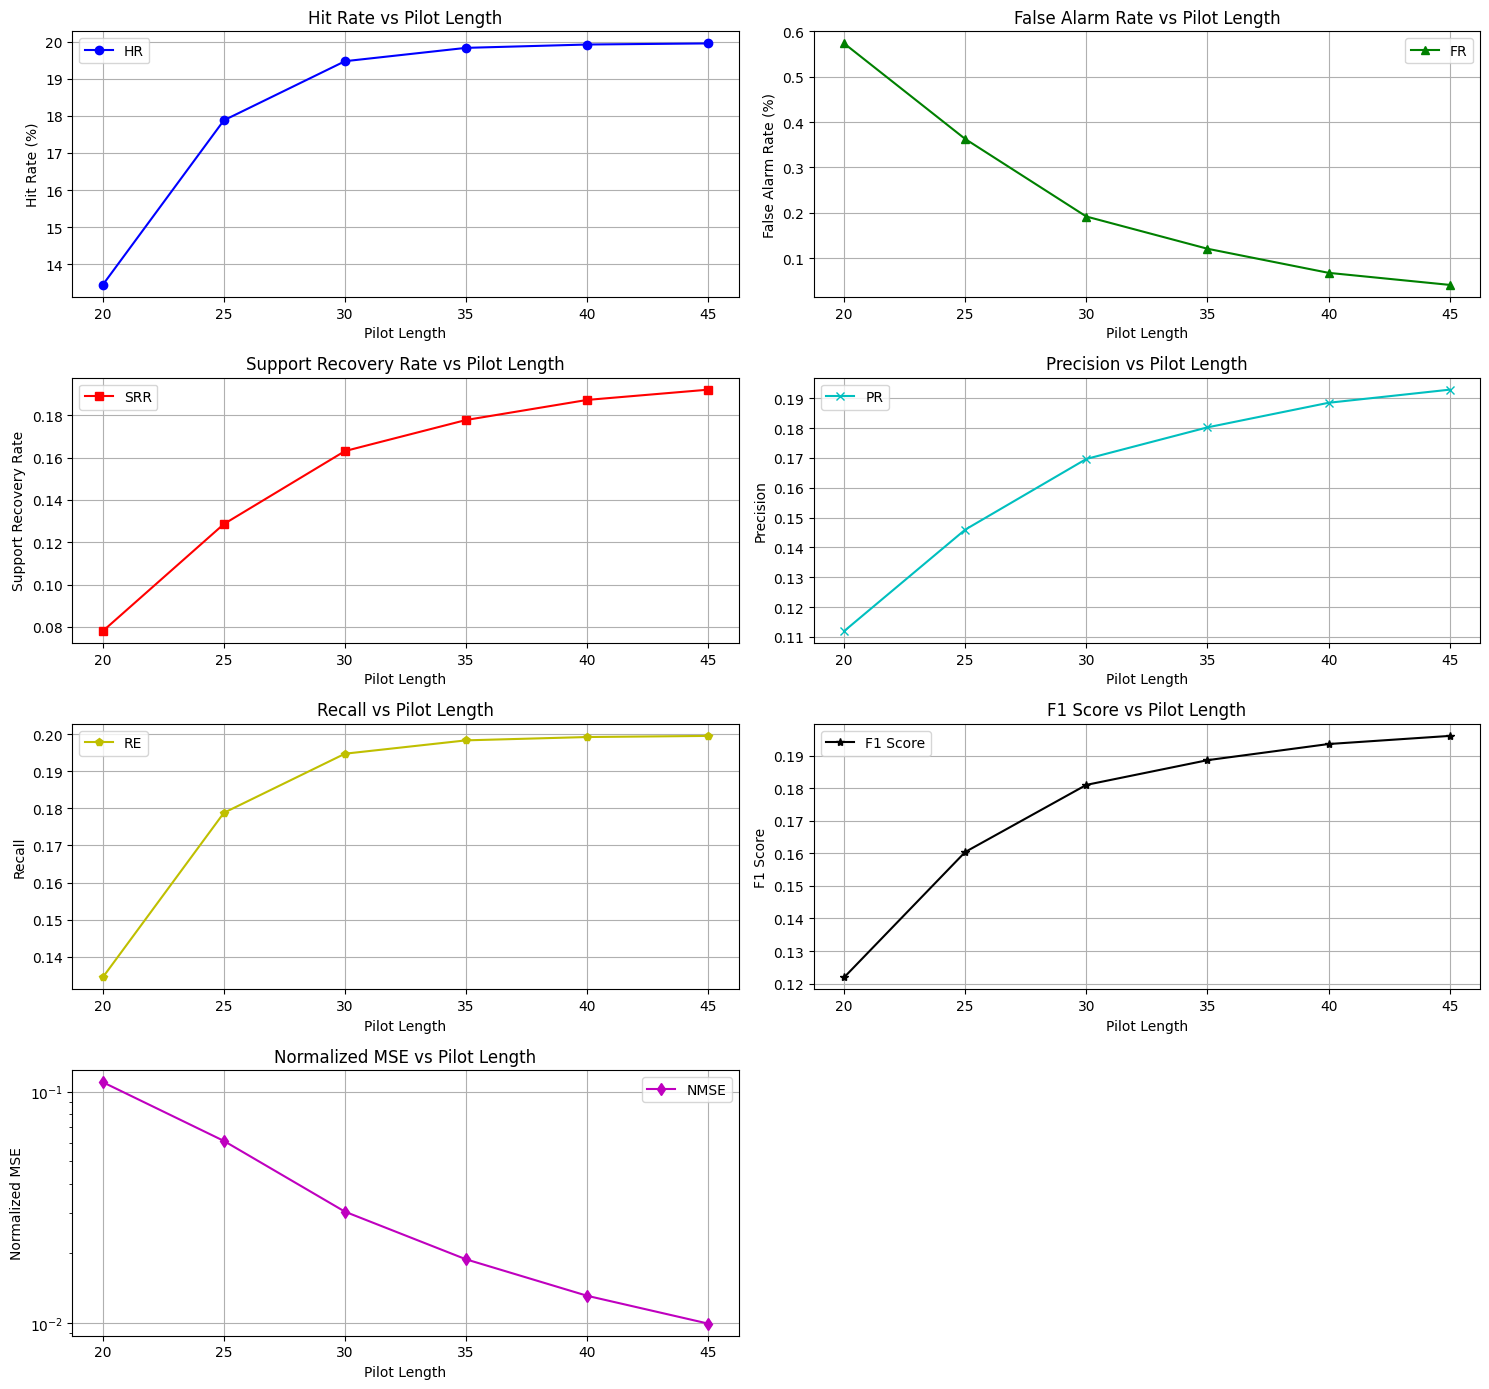

In [9]:
import matplotlib.pyplot as plt

# Define the SNR values for x-axis
pilot_length_values = pilot_length_array

# Create subplots for different performance metrics
plt.figure(figsize=(15, 14))

# Plot Hit Rate (HR)
plt.subplot(4, 2, 1)
plt.plot(pilot_length_values, avg_hr, marker='o', linestyle='-', color='b', label='HR')
plt.xlabel("Pilot Length")
plt.ylabel("Hit Rate (%)")
plt.title("Hit Rate vs Pilot Length")
plt.grid(True)
plt.legend()

# Plot False Alarm Rate (FR)
plt.subplot(4, 2, 2)
plt.plot(pilot_length_values, avg_fr, marker='^', linestyle='-', color='g', label='FR')
plt.xlabel("Pilot Length")
plt.ylabel("False Alarm Rate (%)")
plt.title("False Alarm Rate vs Pilot Length")
plt.grid(True)
plt.legend()

# Plot Support Recovery Rate (SRR)
plt.subplot(4, 2, 3)
plt.plot(pilot_length_values, avg_srr, marker='s', linestyle='-', color='r', label='SRR')
plt.xlabel("Pilot Length")
plt.ylabel("Support Recovery Rate")
plt.title("Support Recovery Rate vs Pilot Length")
plt.grid(True)
plt.legend()

# Plot Precision (PR)
plt.subplot(4, 2, 4)
plt.plot(pilot_length_values, avg_pr, marker='x', linestyle='-', color='c', label='PR')
plt.xlabel("Pilot Length")
plt.ylabel("Precision")
plt.title("Precision vs Pilot Length")
plt.grid(True)
plt.legend()

# Plot Recall (RE)
plt.subplot(4, 2, 5)
plt.plot(pilot_length_values, avg_re, marker='p', linestyle='-', color='y', label='RE')
plt.xlabel("Pilot Length")
plt.ylabel("Recall")
plt.title("Recall vs Pilot Length")
plt.grid(True)
plt.legend()

# Plot F1 Score (F1)
plt.subplot(4, 2, 6)
plt.plot(pilot_length_values, avg_f1, marker='*', linestyle='-', color='k', label='F1 Score')
plt.xlabel("Pilot Length")
plt.ylabel("F1 Score")
plt.title("F1 Score vs Pilot Length")
plt.grid(True)
plt.legend()

# Plot Normalized MSE (NMSE)
plt.subplot(4, 2, 7)
plt.plot(pilot_length_values, avg_nmse, marker='d', linestyle='-', color='m', label='NMSE')
plt.xlabel("Pilot Length")
plt.ylabel("Normalized MSE")
plt.title("Normalized MSE vs Pilot Length")
plt.yscale('log')  # Log scale for better visualization
plt.grid(True)
plt.legend()

# Adjust layout and show the plots
plt.tight_layout()
plt.show()


In [10]:
import matplotlib.pyplot as plt
import numpy as np

def plot_res_vs_ground_truth(sbl_results, Z, sample_index, snr_index, snr_value):
    """Plot sbl reconstructed signal vs ground truth (Z) for a single sample at a given SNR."""
    plt.figure(figsize=(10, 5))

    # Ground truth (Z)
    plt.plot(np.abs(Z[sample_index,:,0]), marker='s', linestyle='--', color='g', label="Ground Truth (Z)")

    # sbl Estimated Signal
    plt.plot(np.abs(sbl_results[sample_index, snr_index, :, 0]), marker='o', linestyle='-', color='b', label="sbl Estimate")

    plt.xlabel("Device Index")
    plt.ylabel("Magnitude of Signal")
    plt.title(f"sbl vs. Ground Truth (Sample {sample_index}, SNR {snr_value} dB)")
    plt.legend()
    plt.grid(True)
    plt.show()

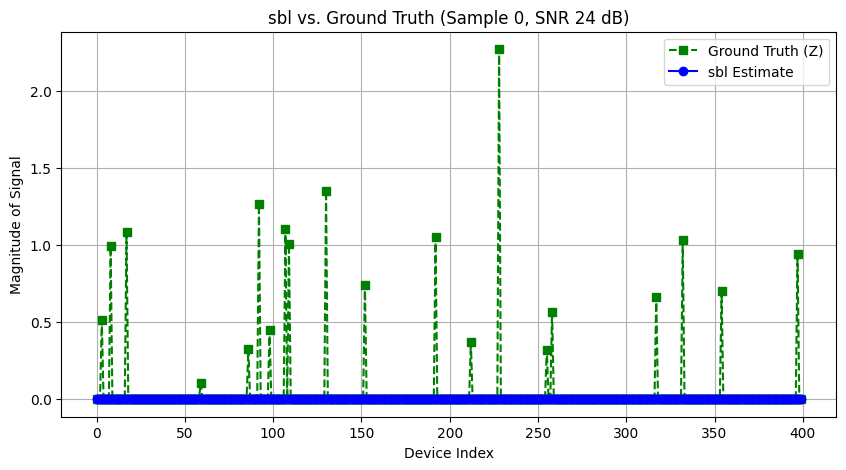

In [11]:
sample_index = 0  # Choose a specific sample
snr_index = 5  # Choose a specific SNR index
snr_value = snr_db_array[snr_index]

plot_res_vs_ground_truth(z_res, all_z, sample_index, snr_index, snr_value)

In [12]:
import matplotlib.pyplot as plt
import numpy as np

def plot_gamma_res_vs_ground_truth(gamma_res, gamma_true, sample_index, snr_index, snr_value):
    """Plot sbl estimated gamma vs ground truth gamma for a single sample at a given SNR."""
    plt.figure(figsize=(10, 5))

    device_indices = np.arange(len(gamma_true[sample_index]))  # X-axis: Device indices

    # Plot ground truth gamma (binary)
    plt.stem(device_indices, gamma_true[sample_index], linefmt='g--', markerfmt='gs', basefmt=" ", label="Ground Truth (γ)")

    # Plot sbl estimated gamma
    plt.stem(device_indices, gamma_res[sample_index, snr_index], linefmt='b-', markerfmt='bo', basefmt=" ", label="sbl Estimate (γ)")

    plt.xlabel("Device Index")
    plt.ylabel("Activity Indicator (0=Inactive, 1=Active)")
    plt.title(f"Device Activity (sbl vs. Ground Truth) - Sample {sample_index}, SNR {snr_value} dB")
    plt.legend()
    plt.grid(True)
    plt.show()


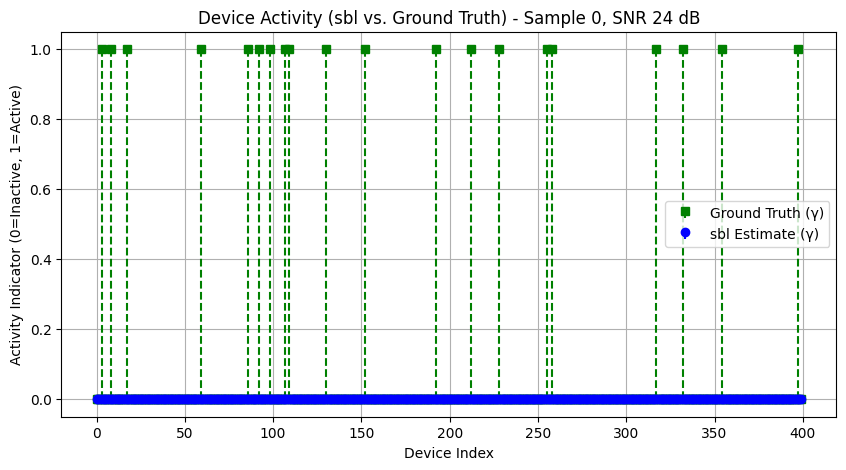

In [13]:
sample_index = 0  # Choose a specific sample
snr_index = 5  # Choose a specific SNR index
snr_value = snr_db_array[snr_index]

plot_gamma_res_vs_ground_truth(gamma_res, all_gamma, sample_index, snr_index, snr_value)